## Imports

In [1]:
import os
import random
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow.keras.backend as K

import warnings
warnings.filterwarnings("ignore")

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data

In [2]:
DATA_DIR = "../input/train_data/"
DATA_DIR_PATH = Path(DATA_DIR)

for dirpath in DATA_DIR_PATH.glob("**/"):
    dirnames = [d for d in dirpath.iterdir() if d.is_dir()]
    filenames = [f for f in dirpath.iterdir() if f.is_file()]
    print(
        f"There are {len(dirnames)} directories and {len(filenames)} images in [{dirpath}]."
    )


print("\nTotal Training Images:", len(list(DATA_DIR_PATH.glob("*/*"))))    

# import os

# for dirpath, dirnames, filenames in os.walk(DATA_DIR):
#   print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in [..\input\train_data].
There are 0 directories and 200 images in [..\input\train_data\driving_license].
There are 0 directories and 200 images in [..\input\train_data\others].
There are 0 directories and 200 images in [..\input\train_data\social_security].

Total Training Images: 600


In this code, we use `Path.glob("**/")` to recursively iterate over all directories within the `DATA_DIR`. For each `dirpath`, we filter the items using `is_dir()` and `is_file()` methods to separate `dirnames` and `filenames` accordingly. Finally, we print the information about the number of directories and files in each directory path.

* **

- What is the meaning of this `**/` in above code?

    - The `**/` in the `Path.glob()` method is a special pattern that matches all directories and subdirectories recursively.

    - When using `**/` in the pattern, it matches zero or more directories, including all subdirectories. It allows us to traverse through the entire directory structure recursively.

    - So, in the code snippet, `DATA_DIR.glob("**/")` will iterate over all directories and subdirectories within `DATA_DIR`.
    

* **

- What is the meaning of this `*/*` in the same context?

In the context of `*/*`, it matches files or directories that are one level deep within the current directory.

Let's consider a directory structure similar to the previous example:

```
- DATA_DIR
  - dir1
    - file1.txt
    - file2.txt
  - dir2
    - file3.txt
    - file4.txt
  - dir3
    - subdir1
      - file5.txt
```

If we use `DATA_DIR.glob("*/*")`, it will match and iterate over files or directories that are one level deep within `DATA_DIR`. In this case, it will match `file1.txt`, `file2.txt`, `file3.txt`, and `file4.txt` because they are directly inside their respective subdirectories (`dir1`, `dir2`). It will not match `subdir1` or `file5.txt` because they are two levels deep within `DATA_DIR`.

So, `*/*` matches files or directories that are one level deep within the current directory, but it does not match files or directories that are nested further.

## Visualize Random Images

In [3]:
list(DATA_DIR_PATH.glob('*/'))

[WindowsPath('../input/train_data/driving_license'),
 WindowsPath('../input/train_data/others'),
 WindowsPath('../input/train_data/social_security')]

In [4]:
list(DATA_DIR_PATH.glob('*/'))[0].name

'driving_license'

In [5]:
list(DATA_DIR_PATH.glob('*/'))[0].stem

'driving_license'

In [6]:
# list(list(DATA_DIR_PATH.glob('*/'))[0].glob('*/'))

In [7]:
list(list(DATA_DIR_PATH.glob('*/'))[0].glob('*/'))[0].name

'1.png'

In [8]:
list(list(DATA_DIR_PATH.glob('*/'))[0].glob('*/'))[0].stem

'1'

In [9]:
import random
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

FIGSIZE = (10, 10)

def view_random_images(data_dir_path: Path = DATA_DIR_PATH):
    fig, axes = plt.subplots(3, len(list(data_dir_path.glob('*/'))), figsize=FIGSIZE)
    for i, img_classes_dir in enumerate(data_dir_path.glob('*/')):
        random_image_paths = random.sample(list(img_classes_dir.glob('*/')), 3)
        for j, random_img in enumerate(random_image_paths):
            ax = axes[j, i]
            img = mpimg.imread(random_img)
            ax.imshow(img)
            ax.set_title(f"Class: {img_classes_dir.name}\nFile Name: {random_img.name}\nImg Shape: {img.shape}")
            ax.axis("off")
    plt.tight_layout()
    plt.show()


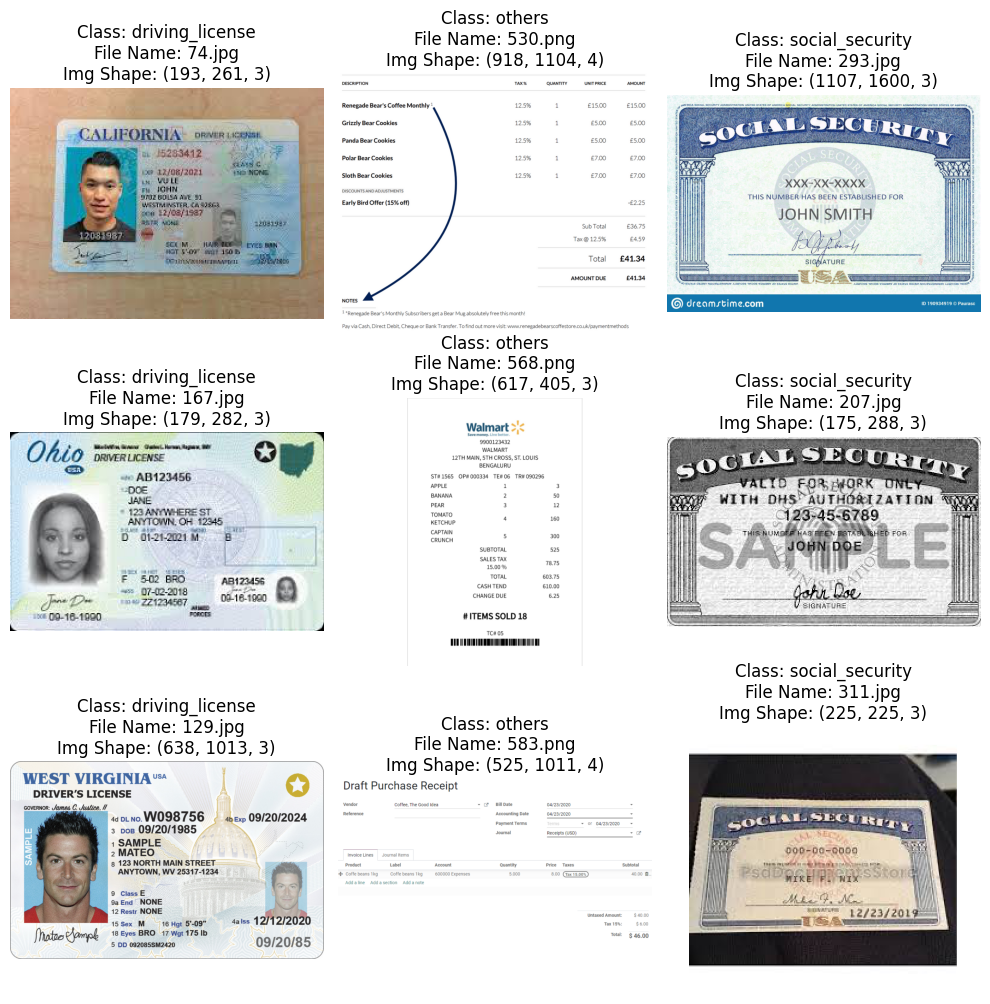

In [10]:
view_random_images()

## Preparing the Data for Model Training

In [3]:
TRAIN_DATA_DIR = "../input/train_data/"
TRAIN_DATA_DIR = Path(TRAIN_DATA_DIR)

TEST_DATA_DIR = "../input/test_data/"
TEST_DATA_DIR = Path(TEST_DATA_DIR)

BATCH_SIZE = 32
IMG_HEIGHT, IMG_WIDTH = 180, 180
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3) # 3 color channels

SEED = 42

In [4]:
train_ds = keras.utils.image_dataset_from_directory(directory=TRAIN_DATA_DIR,
                                                    label_mode='categorical',
                                                    batch_size=BATCH_SIZE,
                                                    image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    validation_split=0.2,
                                                    seed=SEED,
                                                    subset='training')

print()

val_ds = keras.utils.image_dataset_from_directory(directory=TRAIN_DATA_DIR,
                                                  label_mode='categorical',
                                                  batch_size=BATCH_SIZE,
                                                  image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                  validation_split=0.2,
                                                  seed=SEED,
                                                  subset='validation')

Found 600 files belonging to 3 classes.
Using 480 files for training.

Found 600 files belonging to 3 classes.
Using 120 files for validation.


Can also use [`tf.keras.preprocessing.image.ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) but not recommeded as per documentation[Deprecated]

In [3]:
# train_ds, val_ds = keras.utils.image_dataset_from_directory(directory=TRAIN_DATA_DIR,
#                                                             label_mode='categorical',
#                                                             batch_size=BATCH_SIZE,
#                                                             image_size=(IMG_HEIGHT, IMG_WIDTH),
#                                                             validation_split=0.2,
#                                                             seed=SEED,
#                                                             subset='both')

Found 600 files belonging to 3 classes.
Using 480 files for training.
Using 120 files for validation.


In [5]:
class_names = train_ds.class_names
class_names

['driving_license', 'others', 'social_security']

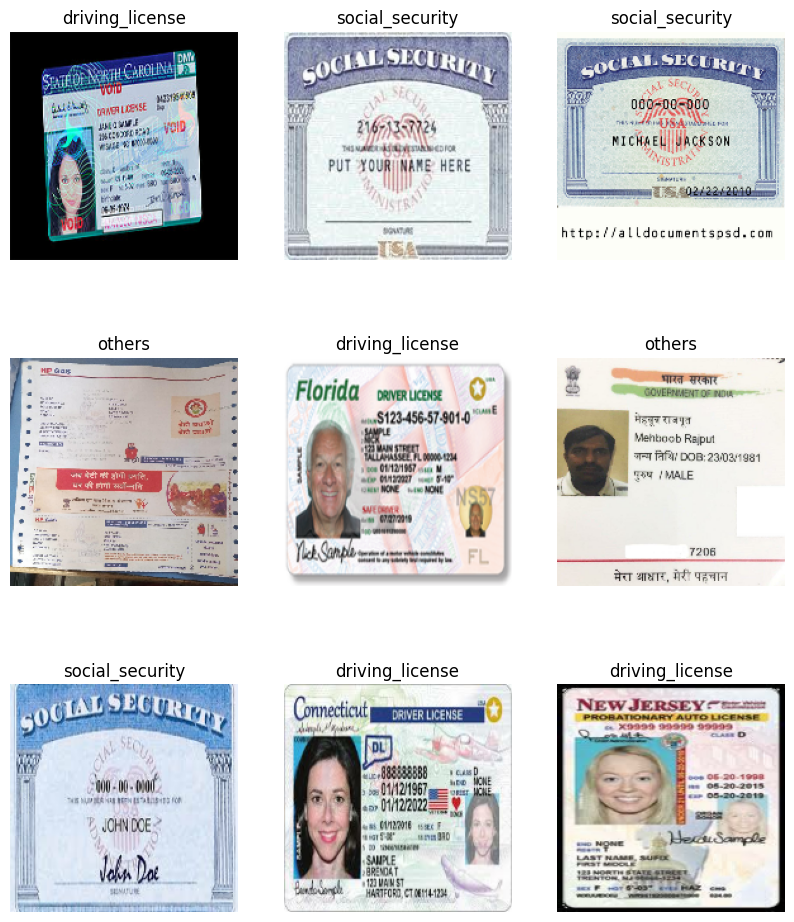

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[tf.argmax(labels[i])])
        plt.axis("off")
        
plt.show();

In [16]:
for image_batch, label_batch in train_ds:
    print("Image Batch Size:", image_batch.shape, "\n--> 32 images of size (180,180) with 3 color channels")
    print("Batch Size:", label_batch.shape)
    print("--> One-Hot Encoding of labels")
    break

Image Batch Size: (32, 180, 180, 3) 
--> 32 images of size (180,180) with 3 color channels
Batch Size: (32, 3)
--> One-Hot Encoding of labels


### Using Tensorflow `prefetch` & `cache` functionality for faster Pipeline Performance

#### [**Documentation on Prefetching & Caching**](https://www.tensorflow.org/guide/data_performance#optimize_performance)

#### [Optimize Tensorflow Pipeline Performance: prefetch & cache - Codebasics](https://youtu.be/MLEKEplgCas)

- **In a naive synchronous implementation of the training pipeline, while your pipeline is fetching the data, your model is sitting idle. Conversely, while your model is training, the input pipeline is sitting idle. The training step time is thus the sum of opening, reading and training times.**

<div align='center'>
    <img src='images/naive.png'/>
</div>

* **

- [Prefetching:](https://www.tensorflow.org/guide/data_performance#prefetching)
    - **Prefetching overlaps the preprocessing and model execution of a training step. While the model is executing training step s, the input pipeline is reading the data for step s+1. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.**
    
    - **The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step.** You could either manually tune this value, or set it to `tf.data.AUTOTUNE`, which will tune the value dynamically at runtime.
    
<div align='center'>
    <img src='images/prefetched.png'/>
</div>

* **

- [Caching:](https://www.tensorflow.org/guide/data_performance#caching)
    - The `tf.data.Dataset.cache` transformation can cache a dataset, either in memory or on local storage. This will save some operations (like file opening and data reading) from being executed during each epoch.
    
    - Below, the data execution time plot shows that when you cache a dataset, the transformations before the `cache` one (like the file opening and data reading) are executed only during the first epoch. The next epochs will reuse the data cached by the `cache` transformation.
<div align='center'>
    <img src='images/cached_dataset.png'/>
</div>

* **

- So, Caching & Prefetching can be used simultaniously for optimum performance of the pipeline 

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(buffer_size=1000).prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

> 🗝️StackOverFlow: [What does batch, repeat, and shuffle do with TensorFlow Dataset?](https://stackoverflow.com/questions/53514495/what-does-batch-repeat-and-shuffle-do-with-tensorflow-dataset)

> 🗝️StackOverFlow: [Meaning of buffer_size in Dataset.map , Dataset.prefetch and Dataset.shuffle](https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle)

### Image Rescaling

In [18]:
# Normalizing
normalizarion_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalizarion_layer(x), y))

image_batch, label_batch = next(normalized_ds.as_numpy_iterator())

first_image = image_batch[0]

print(f"Image Batch Shape: {image_batch.shape}\nLabel Batch Shape: {label_batch.shape}")

# Notice the pixel values are now in `[0,1]`.
print("Min Pixel Value:", np.min(first_image),\
      "\nMax Pixel Value:", np.max(first_image))

Image Batch Shape: (32, 180, 180, 3)
Label Batch Shape: (32, 3)
Min Pixel Value: 0.0 
Max Pixel Value: 0.99389917


## Model Building - Sequential API


1. [Sparse Categorical Cross-Entropy vs Categorical Cross-Entropy](https://fmorenovr.medium.com/sparse-categorical-cross-entropy-vs-categorical-cross-entropy-ea01d0392d28)

    - [stack Exchange on same](https://stats.stackexchange.com/questions/326065/cross-entropy-vs-sparse-cross-entropy-when-to-use-one-over-the-other)
    - [stack Overflow on same](https://stackoverflow.com/questions/58565394/what-is-the-difference-between-sparse-categorical-crossentropy-and-categorical-c)

2. [How to Choose Loss Functions When Training Deep Learning Neural Networks - machinelearningmastery](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/)

In [6]:
# IMG_HEIGHT, IMG_WIDTH = 180, 180
# IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3) # 3 color channels

NUM_CLASSES = len(class_names)
NUM_CLASSES

3

### Model Experiment - 1

```
(Conv2D(16, 3), MaxPool2D) --> (Conv2D(32, 3), MaxPool2D) --> (Conv2D(64,3), MaxPool2D) --> DenseLayer(128) --> DenseLayer(NUM_CLASSES)

with relu & softmax activation
```

In [11]:
# Build the model
model = models.Sequential()
model.add(layers.Rescaling(scale=1./255, input_shape=IMG_SHAPE))

model.add(layers.Convolution2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(NUM_CLASSES, activation='softmax')) # activation='softmax'


# Comilpile the model
model.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy', # keras.losses.SparseCategoricalCrossentropy(from_logits=True)
              metrics=['accuracy'])

# Model Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [12]:
# Fit the model

EPOCHS = 20

history = model.fit(train_ds, 
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    workers=10)

Epoch 1/20
15/15 [==============================] - 2s 50ms/step - loss: 1.5496 - accuracy: 0.4146 - val_loss: 1.0046 - val_accuracy: 0.8583
Epoch 2/20
15/15 [==============================] - 0s 19ms/step - loss: 0.8354 - accuracy: 0.7000 - val_loss: 0.5030 - val_accuracy: 0.8500
Epoch 3/20
15/15 [==============================] - 0s 19ms/step - loss: 0.4422 - accuracy: 0.8292 - val_loss: 0.3611 - val_accuracy: 0.8583
Epoch 4/20
15/15 [==============================] - 0s 19ms/step - loss: 0.3851 - accuracy: 0.8646 - val_loss: 0.3016 - val_accuracy: 0.8833
Epoch 5/20
15/15 [==============================] - 0s 19ms/step - loss: 0.2337 - accuracy: 0.9208 - val_loss: 0.2465 - val_accuracy: 0.9083
Epoch 6/20
15/15 [==============================] - 0s 19ms/step - loss: 0.1739 - accuracy: 0.9417 - val_loss: 0.2105 - val_accuracy: 0.9000
Epoch 7/20
15/15 [==============================] - 0s 19ms/step - loss: 0.1560 - accuracy: 0.9458 - val_loss: 0.1651 - val_accuracy: 0.9417
Epoch 8/20
15

In [15]:
train_score = model.evaluate(train_ds)
print(f"\nTrain score: {train_score[0]}")
print(f'Train accuracy: {train_score[1]}\n')

val_score = model.evaluate(val_ds)
print("\nValidation score:", val_score[0])
print('Validation accuracy:', val_score[1])

15/15 [==============================] - 0s 14ms/step - loss: 8.7771e-04 - accuracy: 1.0000

Train score: 0.0008777134935371578
Train accuracy: 1.0

4/4 [==============================] - 0s 9ms/step - loss: 0.0899 - accuracy: 0.9500

Validation score: 0.08987153321504593
Validation accuracy: 0.949999988079071


- **Model is slightly overfitting on train data**

    - We can reduce # of EPOCHS
    - Try Data Augmentation

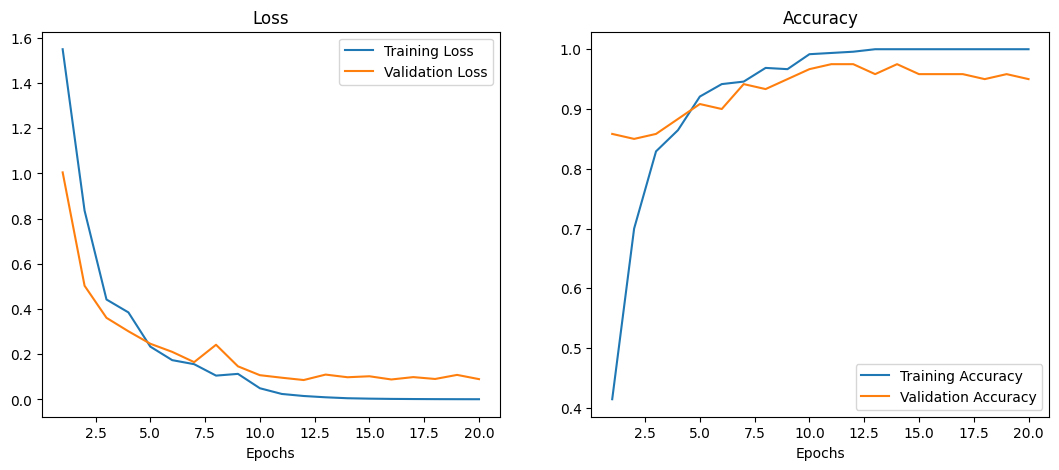

In [22]:
from helper_functions import plot_loss_curves

plot_loss_curves(history)

### Model Experiment - 2 : Data Augmentation

> Less Data: We have only 200 images per category

> Ignore tensorflow warnings: [`tf.get_logger().setLevel('ERROR')`](https://www.tensorflow.org/api_docs/python/tf/get_logger)

In [20]:
INPUT_SHAPE

(180, 180, 3)

In [25]:
K.clear_session()

In [26]:
# Ignore tensorflow warnings
tf.get_logger().setLevel('ERROR')

data_augmentation = models.Sequential(name="data_augmentation")

data_augmentation.add(layers.InputLayer(input_shape=INPUT_SHAPE))
data_augmentation.add(layers.RandomFlip(mode='horizontal'))
data_augmentation.add(layers.RandomRotation(0.1))
data_augmentation.add(layers.RandomZoom(0.1))
data_augmentation.add(layers.Rescaling(1./255))


data_augmentation.summary()
# data_augmentation.add(layers.RandomHeight(0.1))
# data_augmentation.add(layers.RandomWidth(0.1))

# data_augmentation.add(preprocessing.RandomFlip(mode='horizontal'))
# data_augmentation.add(preprocessing.RandomRotation(0.1))
# data_augmentation.add(preprocessing.RandomZoom(0.1))
# data_augmentation.add(preprocessing.RandomHeight(0.1))
# data_augmentation.add(preprocessing.RandomWidth(0.1))

Model: "data_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 180, 180, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


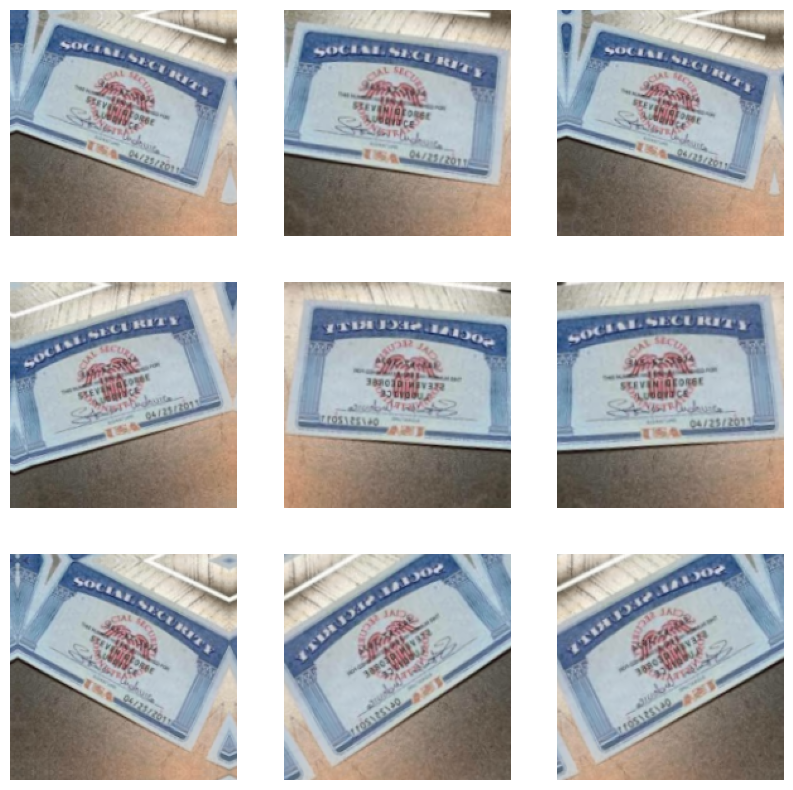

In [29]:
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy()) # .astype("uint8")
        plt.axis("off")
    break

In [41]:
K.clear_session()

In [42]:
INPUT_SHAPE, NUM_CLASSES

((180, 180, 3), 3)

In [43]:
# Build the model
model = models.Sequential()

# adding augmentation layer
# model.add(layers.Input(shape=INPUT_SHAPE))
model.add(data_augmentation)

model.add(layers.Convolution2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
# model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(NUM_CLASSES, activation='softmax')) # activation='softmax'


# Comilpile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy', # keras.losses.SparseCategoricalCrossentropy(from_logits=True)
              metrics=['accuracy'])

# Model Summary
# model.summary()

In [44]:
# Fit the model
EPOCHS = 20

history = model.fit(train_ds, 
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    workers=10)

Epoch 1/20
15/15 [==============================] - 7s 239ms/step - loss: 1.7100 - accuracy: 0.3521 - val_loss: 0.9943 - val_accuracy: 0.7167
Epoch 2/20
15/15 [==============================] - 3s 233ms/step - loss: 0.9139 - accuracy: 0.6187 - val_loss: 0.5961 - val_accuracy: 0.7917
Epoch 3/20
15/15 [==============================] - 3s 229ms/step - loss: 0.7363 - accuracy: 0.6896 - val_loss: 0.4246 - val_accuracy: 0.8417
Epoch 4/20
15/15 [==============================] - 3s 233ms/step - loss: 0.4392 - accuracy: 0.8292 - val_loss: 0.6040 - val_accuracy: 0.7250
Epoch 5/20
15/15 [==============================] - 3s 234ms/step - loss: 0.4049 - accuracy: 0.8479 - val_loss: 0.4930 - val_accuracy: 0.7833
Epoch 6/20
15/15 [==============================] - 4s 237ms/step - loss: 0.3170 - accuracy: 0.9042 - val_loss: 0.2242 - val_accuracy: 0.9167
Epoch 7/20
15/15 [==============================] - 3s 227ms/step - loss: 0.2365 - accuracy: 0.9104 - val_loss: 0.2304 - val_accuracy: 0.9250
Epoch 

In [45]:
# # Model Summary
# model.summary()

In [46]:
train_score = model.evaluate(train_ds)
print(f"\nTrain score: {train_score[0]}")
print(f'Train accuracy: {train_score[1]}\n')

val_score = model.evaluate(val_ds)
print("\nValidation score:", val_score[0])
print('Validation accuracy:', val_score[1])

15/15 [==============================] - 0s 17ms/step - loss: 0.0760 - accuracy: 0.9771

Train score: 0.07603108882904053
Train accuracy: 0.9770833253860474

4/4 [==============================] - 0s 9ms/step - loss: 0.1778 - accuracy: 0.9167

Validation score: 0.17783784866333008
Validation accuracy: 0.9166666865348816


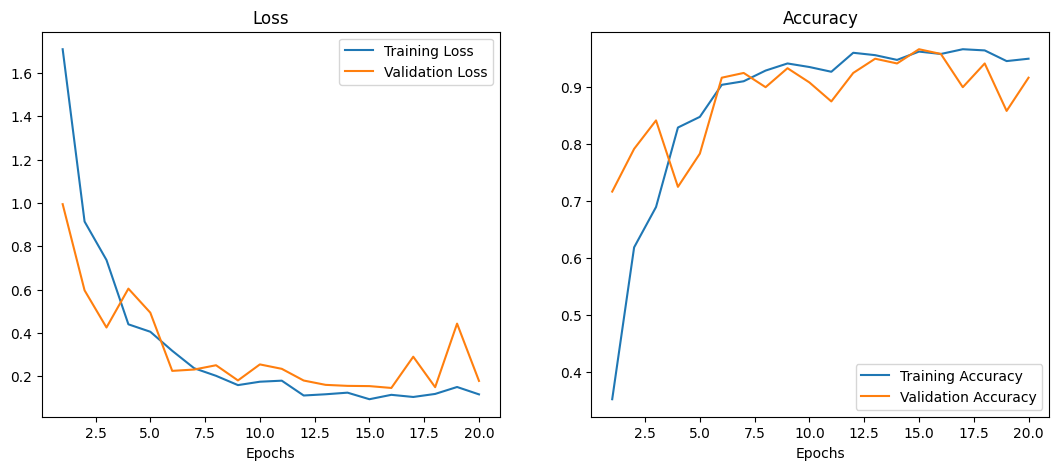

In [47]:
from helper_functions import plot_loss_curves

plot_loss_curves(history)

In [65]:
model.save("../output/saved_model/cnn-classification-model-data-aug.h5")

## Predictions

> Accuracy: 96%

In [7]:
TEST_DATA_DIR = "../input/test_data/"
TEST_DATA_DIR = Path(TEST_DATA_DIR)

TEST_DATA_DIR

WindowsPath('../input/test_data')

In [8]:
test_ds = keras.utils.image_dataset_from_directory(
                        directory=TEST_DATA_DIR,
                        label_mode="categorical",
                        image_size=(IMG_HEIGHT, IMG_WIDTH),
                        seed=SEED)

Found 150 files belonging to 3 classes.


In [9]:
# test_ds.file_paths

In [10]:
model = tf.keras.models.load_model("../output/saved_model/cnn-classification-model-data-aug.h5")

In [11]:
model.evaluate(test_ds)

5/5 [==============================] - 5s 34ms/step - loss: 0.1260 - accuracy: 0.9600


[0.12602490186691284, 0.9599999785423279]

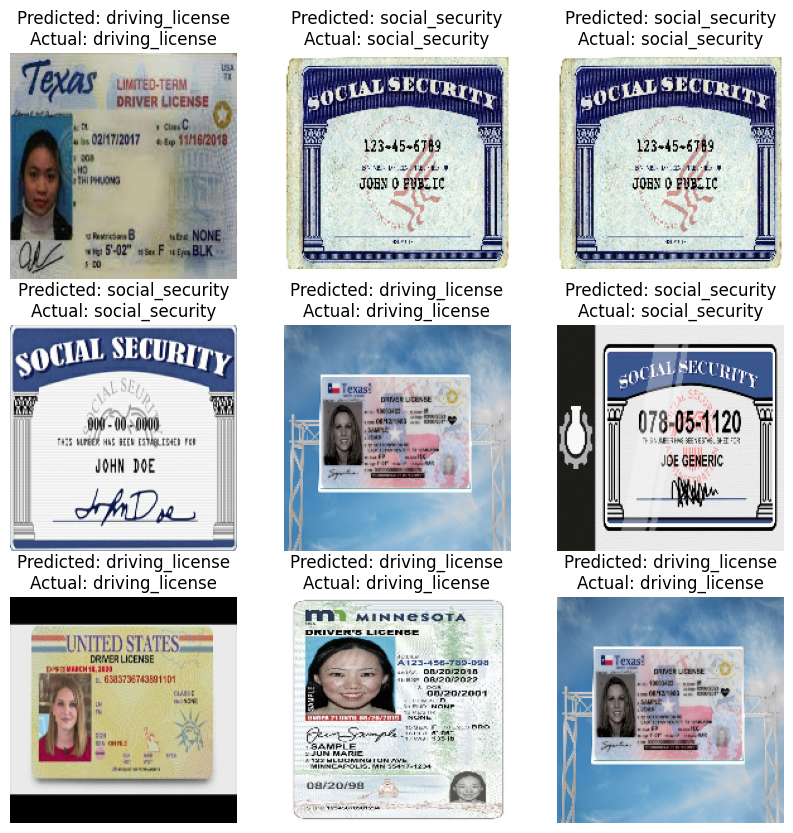

In [40]:
import random
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

images, labels = next(test_ds.as_numpy_iterator())

for i in range(9):
    ax = plt.subplot(3,3, i + 1)

    idx = random.randint(0, len(labels)-1)
    plt.imshow(images[idx].astype("uint8"))

    pred_arr = model.predict(tf.expand_dims(images[idx], axis=0), verbose=0)
    pred = tf.argmax(pred_arr, axis=-1).numpy()[0]
    
    temp = labels[idx].tolist()
    plt.title(f"Predicted: {class_names[pred]}\nActual: {class_names[temp.index(max(temp))]}")
    plt.axis("off")
    
plt.savefig("../output/prediction_4.png")

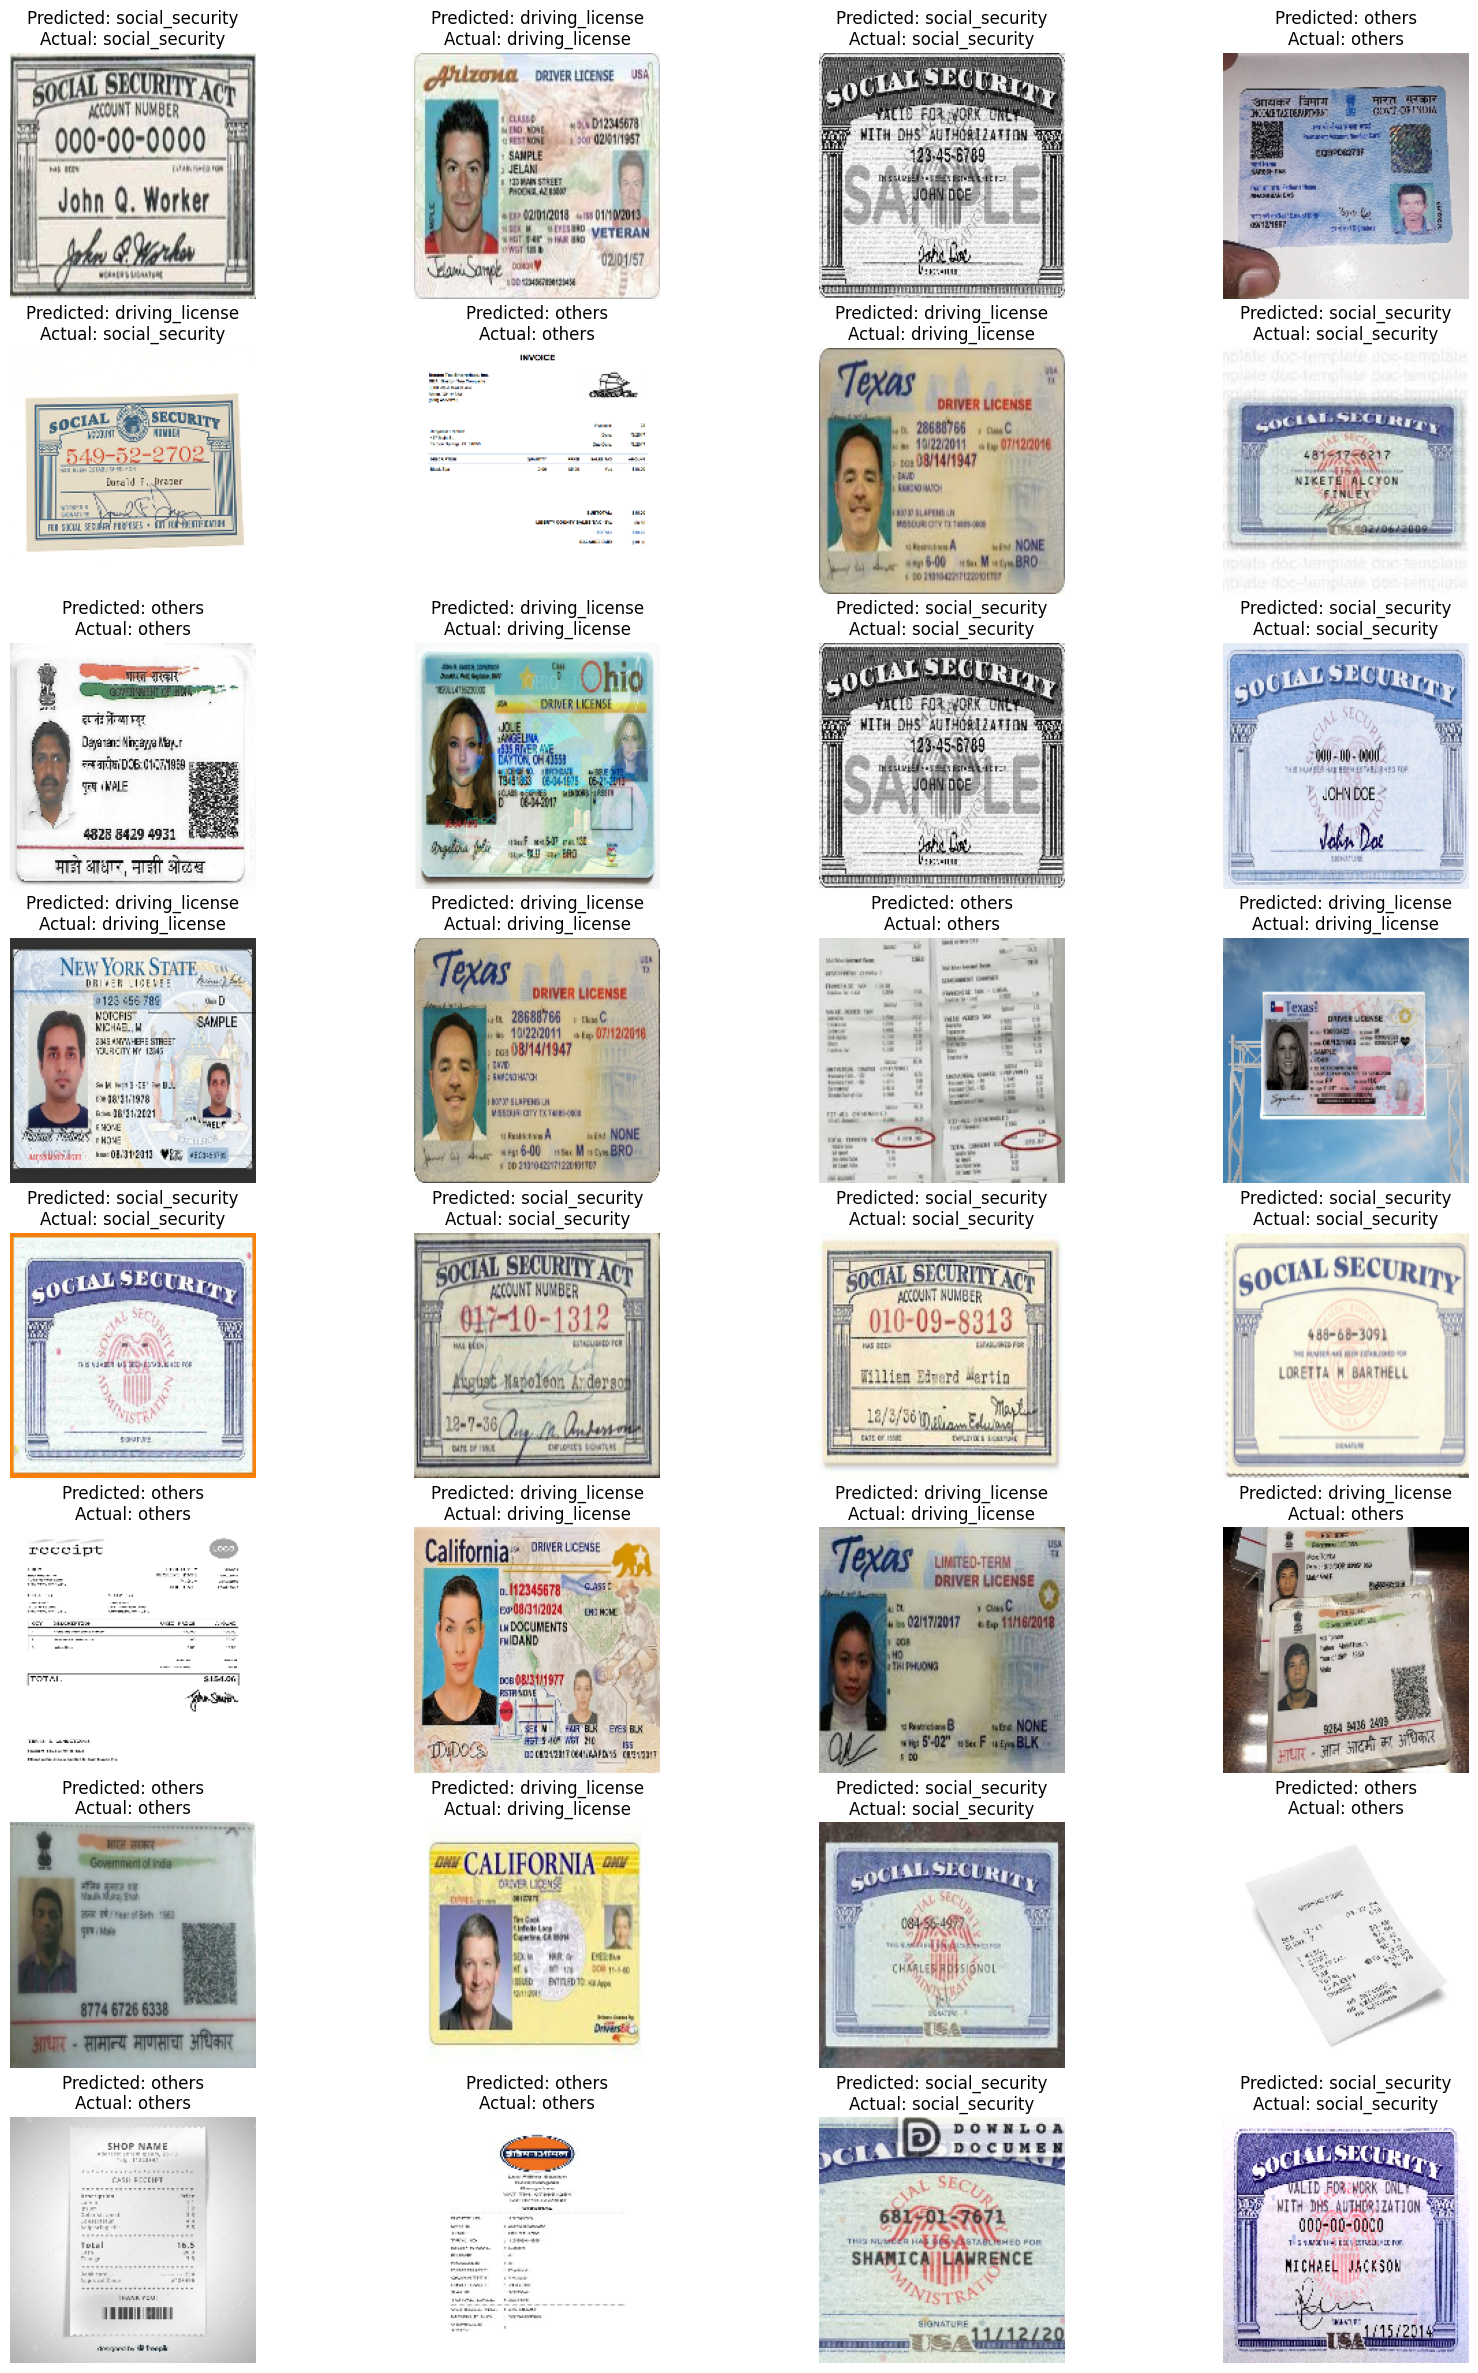

In [37]:
import random
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 30))

images, labels = next(test_ds.as_numpy_iterator())

for i in range(32):
    ax = plt.subplot(8, 4, i + 1)

    # idx = random.randint(0, len(labels)-1)
    idx = i
    plt.imshow(images[idx].astype("uint8"))

    pred_arr = model.predict(tf.expand_dims(images[idx], axis=0), verbose=0)
    pred = tf.argmax(pred_arr, axis=-1).numpy()[0]
    
    temp = labels[idx].tolist()
    plt.title(f"Predicted: {class_names[pred]}\nActual: {class_names[temp.index(max(temp))]}")
    plt.axis("off")
    
plt.savefig("../output/prediction_3.png")

### Predict on random images

In [13]:
import random

In [16]:
class_names = test_ds.class_names
class_names

['driving_license', 'others', 'social_security']

In [18]:
random.sample(test_ds.file_paths, 1)[0]

'..\\input\\test_data\\driving_license\\30.jpg'

In [19]:
import os

In [22]:
os.path.basename(os.path.dirname('..\\input\\test_data\\driving_license\\30.jpg'))

'driving_license'

In [80]:
img_path = random.sample(test_ds.file_paths, 1)[0]

actual_img_class = os.path.basename(os.path.dirname(img_path))

img = tf.keras.utils.load_img(img_path, 
                              target_size=(IMG_HEIGHT, IMG_WIDTH))

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("Actual Image Class: [{}]\nPredicted Image Class: [{}] with {:.2f}% confidence"
      .format(actual_img_class, class_names[np.argmax(score)], 100 * np.max(score))
    )

1/1 [==============================] - 0s 19ms/step
Actual Image Class: [others]
Predicted Image Class: [others] with 48.35% confidence


## Generate requirements.txt

- References:

    - [Reference-1](https://towardsdatascience.com/generating-a-requirements-file-jupyter-notebook-385f1c315b52)
    - [Reference-2](https://stackoverflow.com/questions/51503913/pipreqs-unicodedecodeerror-charmap-codec-cant-decode-byte-0x98-in-position)

- Install

    - `pip install pipreqs`
    - `pip install nbconvert`
    
- Convert your jupyter notebook to .py file

    - `jupyter nbconvert --output-dir="./reqs" --to script "notebook_name.ipynb"`
    - `cd reqs (Navigate to the .py file directory)`

- Run the following command in .py file folder

    - `pipreqs "file_path"`
    - `pipreqs --encoding=utf8 "file_path"` (if above does not works)